In [267]:
#installing regions for Region-wise line plotting
!pip install regions
!pip install nbconvert

# Importing necessary libraries we will need.
import numpy as np
import warnings
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS  #World Coordinate System(convert between pixel coordinates and real-world values)
from regions import Regions

warnings.filterwarnings("ignore", category=UserWarning, append=True)

In [258]:
#for Calculating Pixel Scale in Parsecs:
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u
#loop to get files in order
f=[]
for i in ['1','2','3']:
    for part in ['short','medium','long']:
        f.append(f'C:/Users/Dell/OneDrive/Desktop/JWST_FITS/ch{i}/jw01328-c1006_t014_miri_ch{i}-{part}_s3d.fits')
p_ar=[]  #creating empty list for deg per pixel values
for file in f:
    hdu_list = fits.open(file)
    header = hdu_list[1].header  
    pixel_scale = header['CDELT1']
    p_ar.append(pixel_scale)
    hdu_list.close()
p= np.array(p_ar) #create an array
parc=p*3600 # convert to arcseconds per pixel
z=0.016268
angular_scale = cosmo.arcsec_per_kpc_proper(z)
parsec_per_arcsec = 1 / angular_scale.to(u.arcsec / u.kpc).value * 1000 
p_p_p= parc*parsec_per_arcsec # parsecs per pixels
pc=np.mean(phy_size) # mean value
print(p)
print(parc)
print(p_p_p)
print(pc)

[3.61111098e-05 3.61111098e-05 3.61111098e-05 4.72222227e-05
 4.72222227e-05 4.72222227e-05 5.55555564e-05 5.55555564e-05
 5.55555564e-05]
[0.13 0.13 0.13 0.17 0.17 0.17 0.2  0.2  0.2 ]
[44.53234108 44.53234108 44.53234108 58.23460263 58.23460263 58.23460263
 68.51129751 68.51129751 68.51129751]
57.09274707239006


In [259]:
# For channel 1

z = 0.016268    #redshift 
#giving ds9 region file path and then reading it
reg_path = r"C:\Users\Dell\OneDrive\Desktop\JWST_FITS\d1.reg"
regs = Regions.read(reg_path, format='ds9')
#Creating empty list for spectral cube files for diff channels
f_paths = []
for part in ['short','medium','long']:
    f_paths.append(f'C:/Users/Dell/OneDrive/Desktop/JWST_FITS/ch1/jw01328-c1006_t014_miri_ch{1}-{part}_s3d.fits')   #file's path for 3 channels
print(f_paths)
f=[]
for i in ['1','2','3']:
    for part in ['short','medium','long']:
        f.append(f'C:/Users/Dell/OneDrive/Desktop/JWST_FITS/ch1/jw01328-c1006_t014_miri_ch{1}-{part}_s3d.fits')
print(f)

['C:/Users/Dell/OneDrive/Desktop/JWST_FITS/ch1/jw01328-c1006_t014_miri_ch1-short_s3d.fits', 'C:/Users/Dell/OneDrive/Desktop/JWST_FITS/ch1/jw01328-c1006_t014_miri_ch1-medium_s3d.fits', 'C:/Users/Dell/OneDrive/Desktop/JWST_FITS/ch1/jw01328-c1006_t014_miri_ch1-long_s3d.fits']
['C:/Users/Dell/OneDrive/Desktop/JWST_FITS/ch1/jw01328-c1006_t014_miri_ch1-short_s3d.fits', 'C:/Users/Dell/OneDrive/Desktop/JWST_FITS/ch1/jw01328-c1006_t014_miri_ch1-medium_s3d.fits', 'C:/Users/Dell/OneDrive/Desktop/JWST_FITS/ch1/jw01328-c1006_t014_miri_ch1-long_s3d.fits', 'C:/Users/Dell/OneDrive/Desktop/JWST_FITS/ch1/jw01328-c1006_t014_miri_ch1-short_s3d.fits', 'C:/Users/Dell/OneDrive/Desktop/JWST_FITS/ch1/jw01328-c1006_t014_miri_ch1-medium_s3d.fits', 'C:/Users/Dell/OneDrive/Desktop/JWST_FITS/ch1/jw01328-c1006_t014_miri_ch1-long_s3d.fits', 'C:/Users/Dell/OneDrive/Desktop/JWST_FITS/ch1/jw01328-c1006_t014_miri_ch1-short_s3d.fits', 'C:/Users/Dell/OneDrive/Desktop/JWST_FITS/ch1/jw01328-c1006_t014_miri_ch1-medium_s3d.fit

In [260]:
#looping over regions / iterating over each region of region file
for region in regs: 
    #Empty lists of all spectra, its coreponding error,all wavelength values
     spect_all = []
     spect_all_er = []
     wl_all = []
    #looping over channels and extracting FITS file's data
     for ch_index, f_path in enumerate(f_paths, start=1):
        spect = []
        spect_er = []
        with fits.open(f_path) as hdulist:
            d = hdulist[1].data #data
            d[d < 0] = np.nan  # Mask negative values,so negative values will be NaN
            d_err = hdulist[2].data #error data
            h = hdulist[1].header  #header
        #setting up wcs system
        wcs = WCS(h)
        mask = region.to_pixel(wcs.celestial).to_mask()  #converts the sky region to a pixels and then mask it
        num_ch, ny, nx = d.shape   #Extract the shape of the data cube
        #setting up the wavelength axis
        n_wl = d.shape[0]  #no. of wavelength
        #extract info from header using WCS keywords 
        crval3 = h['CRVAL3']   # CRVAL3 is the reference value of the wavelength axis
        cdelt3 = h['CDELT3']   # CDELT3 is the increment in the wavelength axis
        crpix3 = h['CRPIX3']   # CRPIX3 is the reference pixel of the wavelength axis
        Wl = (np.arange(n_wl) - (crpix3 - 1)) * cdelt3 + crval3
        Wl = Wl / (1 + z) # Convert to rest-frame wavelength
        #loop over wavelength channel
        for i in range(num_ch):
            # 2D image\data  
            #Apply the region mask to both the data and error arrays to extract the info within the region
            masked_d = np.array(mask.multiply(d[i, :, :]), dtype=float)
            masked_d_err = np.array(mask.multiply(d_err[i, :, :]), dtype=float)
            #Calculate average intensity ,ignoring NaNs
            #calculate the error on the average using RMS
            avg_intensity = np.nanmean(masked_d)
            avg_intensity_err = np.sqrt(np.nanmean(masked_d_err**2))
            #Handling NaNs to avoid errors
            if np.isnan(avg_intensity):
                avg_intensity = 0
            if np.isnan(avg_intensity_err):
                avg_intensity_err = 0
            #Now store the results
            # This is done to combine the spectra from all channels into one list
            # This allows us to plot the spectrum across all channels in one go
            # The wavelength and spectrum lists will have the same length
            spect.append(avg_intensity)
            spect_er.append(avg_intensity_err)
           
            wl_all.append(float(Wl[i]))
            spect_all.append(avg_intensity)
            spect_all_er.append(avg_intensity_err)
#printing values
print(len(wl_all))
print(len(spect_all))
print(type(wl_all[0]))
print(type(spect_all[0]))
print(type(spect_all_er[0]))


            

Set DATE-AVG to '2022-07-04T03:54:53.948' from MJD-AVG.
Set DATE-END to '2022-07-04T04:01:02.328' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -38.282938 from OBSGEO-[XYZ].
Set OBSGEO-H to 1737445736.634 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-07-04T04:11:31.595' from MJD-AVG.
Set DATE-END to '2022-07-04T04:17:33.047' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -38.283459 from OBSGEO-[XYZ].
Set OBSGEO-H to 1737461184.323 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-07-04T04:28:21.737' from MJD-AVG.
Set DATE-END to '2022-07-04T04:34:17.654' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -38.283980 from OBSGEO-[XYZ].
Set OBSGEO-H to 1737476718.877 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3663
3663
<class 'float'>
<class 'numpy.float64'>
<class 'numpy.float64'>


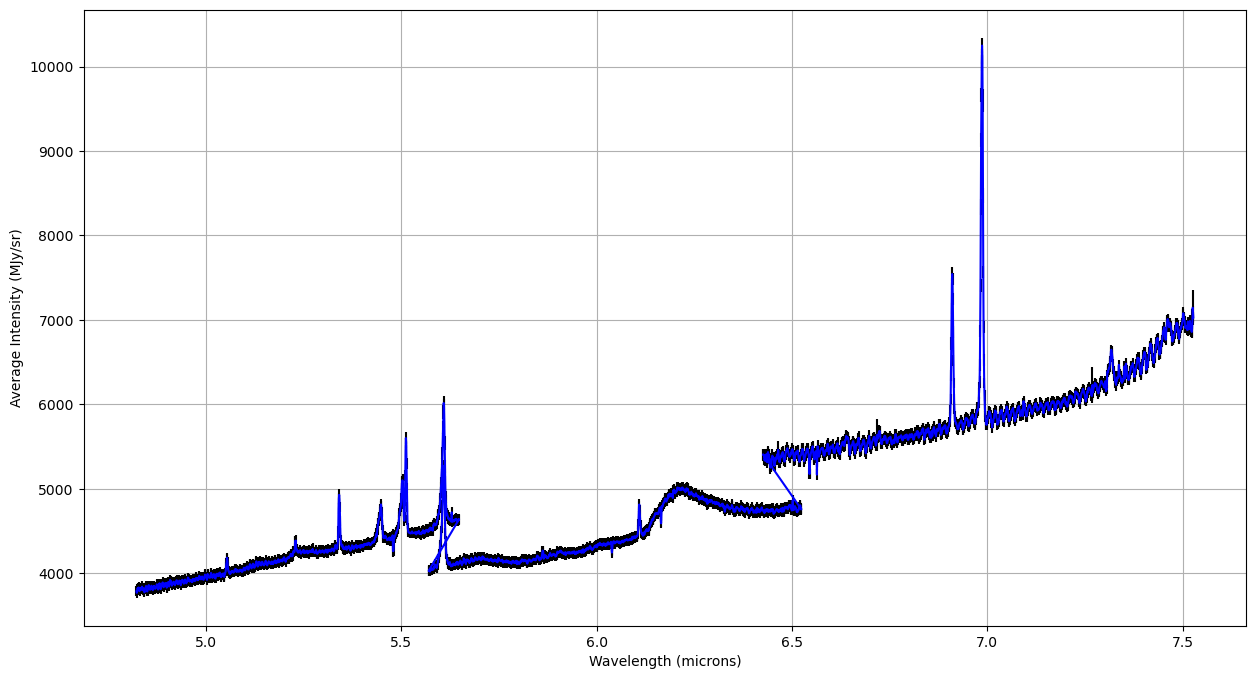

In [261]:
#plotting ,height and width
plt.figure(figsize=(15, 8))
#plot error bar
plt.errorbar(wl_all, spect_all, yerr=spect_all_er, color='blue', ecolor='black')
#labels
plt.xlabel('Wavelength (microns)')
plt.ylabel('Average Intensity (MJy/sr)')
plt.grid(True) #for grids



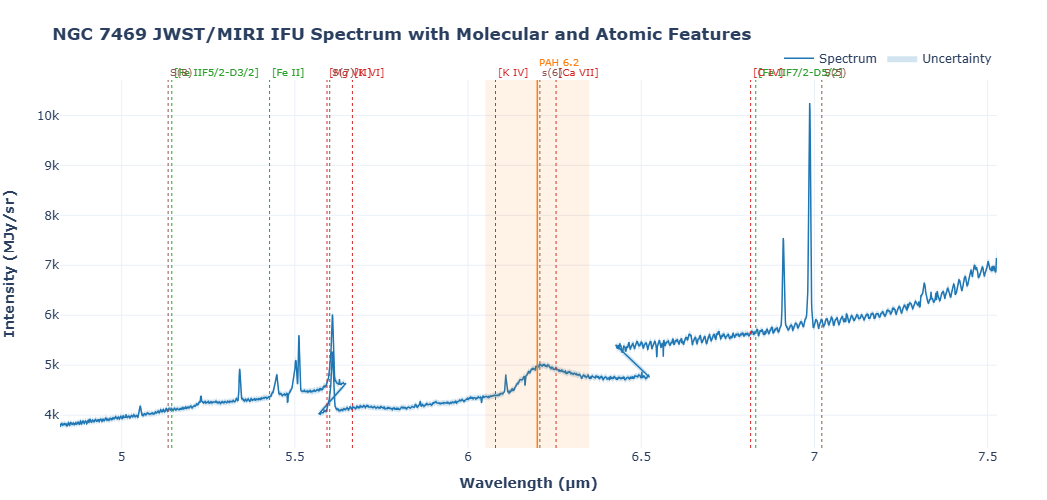

In [262]:
import plotly.graph_objects as go
import numpy as np

# Initialize figure with custom size
fig = go.Figure(layout=dict(
    width=800,  # Width in pixels
    height=500,  # Height in pixels
    template='plotly_white'
))

# Add spectrum trace
fig.add_trace(go.Scatter(
    x=wl_all,
    y=spect_all,
    mode='lines',
    line=dict(color='#1f77b4', width=1.5),
    name='Spectrum',
    hovertemplate='λ: %{x:.3f} μm<br>Intensity: %{y:.2f} MJy/sr<extra></extra>'
))

# Convert list to numpy
spect_all = np.array(spect_all)
spect_all_er = np.array(spect_all_er)

# Convert wavelength list to numpy
wl_all = np.array(wl_all)

# Add error band
fig.add_trace(go.Scatter(
    x=np.concatenate([wl_all, wl_all[::-1]]),
    y=np.concatenate([spect_all + spect_all_er, 
                     (spect_all - spect_all_er)[::-1]]),
    fill='toself',
    fillcolor='rgba(31, 119, 180, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo='skip',
    name='Uncertainty'
))

# Define all spectral features with different categories (edit here)
features = {
    'PAHs': {
          'PAH 6.2': 6.2,
    },
    'Iron': {
        '[Fe IIF5/2-D3/2]' : 5.1446992284599995,
        '[Fe II]' : 5.427042869292,
        #'[Fe IIF7/2-D5/2]' : 5.766210119076,
        '[Fe IIF7/2-D5/2]' : 6.830618734235999
    },
    'other': {
         '[Mg VII]': 5.5928276844,
         #'[Mg V]' : 5.701060226399999,
         #'[Na III]' : 7.436845970399999,
         #'[Ar II]' : 7.098910437432,
         '[C IV]' : 6.815774107559999,
         '[K IV]' : 6.079315176,
         #'[Ni I]' : 5.98914171636,
         '[Ca VII]' : 6.254113272,
         #'[Si VII]' : 6.5979167364,
         #'[Ni II]' : 6.743954448,
         '[K VI]': 5.66618190864, 
    },
    'H₂': {
         'S(5)': 7.021395611999999, 
         'S(7)': 5.600652948,
         's(6)': 6.207364943999999,
         'S(8)': 5.134185936
    }
}

# Add all features with different colors and styles
colors = {
    'PAHs': '#FF7F0E',  # Orange
    'Iron': '#2CA02C',  # Green
    'other': '#D62728',  # Red
    'H₂': '#8C564B'     # Brown
}

# Add vertical lines and annotations
for category, lines in features.items():
    for name, wl in lines.items():
        fig.add_vline(
            x=wl,
            line=dict(
                color=colors[category],
                width=1.5 if category == 'PAHs' else 1,
                dash='dot' if category != 'PAHs' else 'solid'
            ),
            annotation=dict(
                text=name,
                yanchor='bottom',
                font=dict(
                    size=10,
                    color=colors[category]
                ),
                yshift=10 if category == 'PAHs' else 0
            )
        )

# Highlight PAH bands with shaded regions
for wl in [6.2]:  # Add the PAH bands you want to highlight
    # Add a shaded rectangle for each PAH band
    # The rectangle is centered around the wavelength with a width of 0.3 microns
    fig.add_vrect(
        x0=wl-0.15, x1=wl+0.15,
        fillcolor=colors['PAHs'],
        opacity=0.1,
        line_width=0
    )

# Customize layout
fig.update_layout(
    # Title and axis labels
    title='<b>NGC 7469 JWST/MIRI IFU Spectrum with Molecular and Atomic Features</b>',
    xaxis_title='<b>Wavelength (μm)</b>',
    yaxis_title='<b>Intensity (MJy/sr)</b>',
    hovermode='x unified',                    # Unified hover mode for better interaction
    legend=dict(                              # Position the legend outside the plot area
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    ),
    margin=dict(l=50, r=50, b=50, t=80),      # Adjust margins for better spacing
)

fig.show()

['C:/Users/Dell/OneDrive/Desktop/JWST_FITS/ch2/jw01328-c1006_t014_miri_ch2-short_s3d.fits', 'C:/Users/Dell/OneDrive/Desktop/JWST_FITS/ch2/jw01328-c1006_t014_miri_ch2-medium_s3d.fits', 'C:/Users/Dell/OneDrive/Desktop/JWST_FITS/ch2/jw01328-c1006_t014_miri_ch2-long_s3d.fits']


Set DATE-AVG to '2022-07-04T03:54:53.948' from MJD-AVG.
Set DATE-END to '2022-07-04T04:01:02.328' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -38.282938 from OBSGEO-[XYZ].
Set OBSGEO-H to 1737445736.634 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-07-04T04:11:31.595' from MJD-AVG.
Set DATE-END to '2022-07-04T04:17:33.047' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -38.283459 from OBSGEO-[XYZ].
Set OBSGEO-H to 1737461184.323 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-07-04T04:28:21.737' from MJD-AVG.
Set DATE-END to '2022-07-04T04:34:17.654' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -38.283980 from OBSGEO-[XYZ].
Set OBSGEO-H to 1737476718.877 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3394
3394
<class 'float'>
<class 'numpy.float64'>
<class 'numpy.float64'>


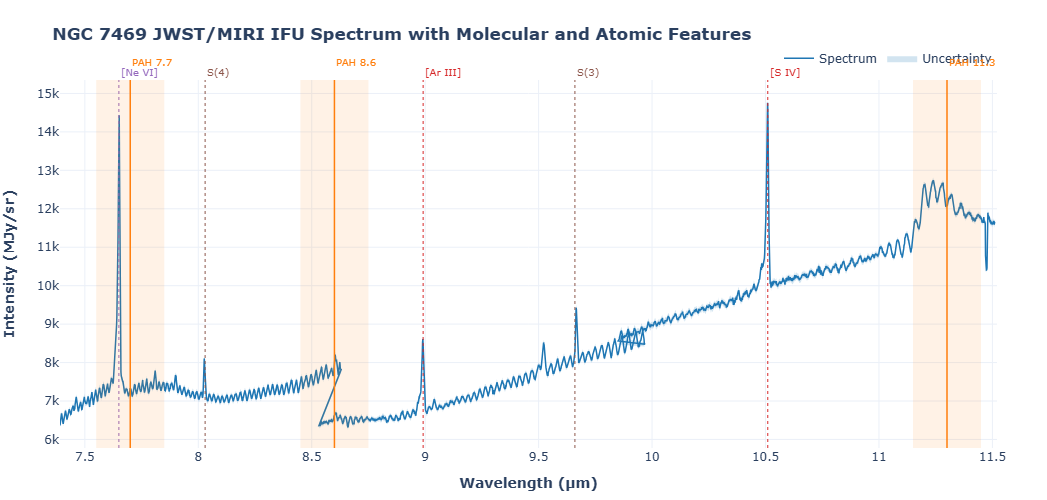

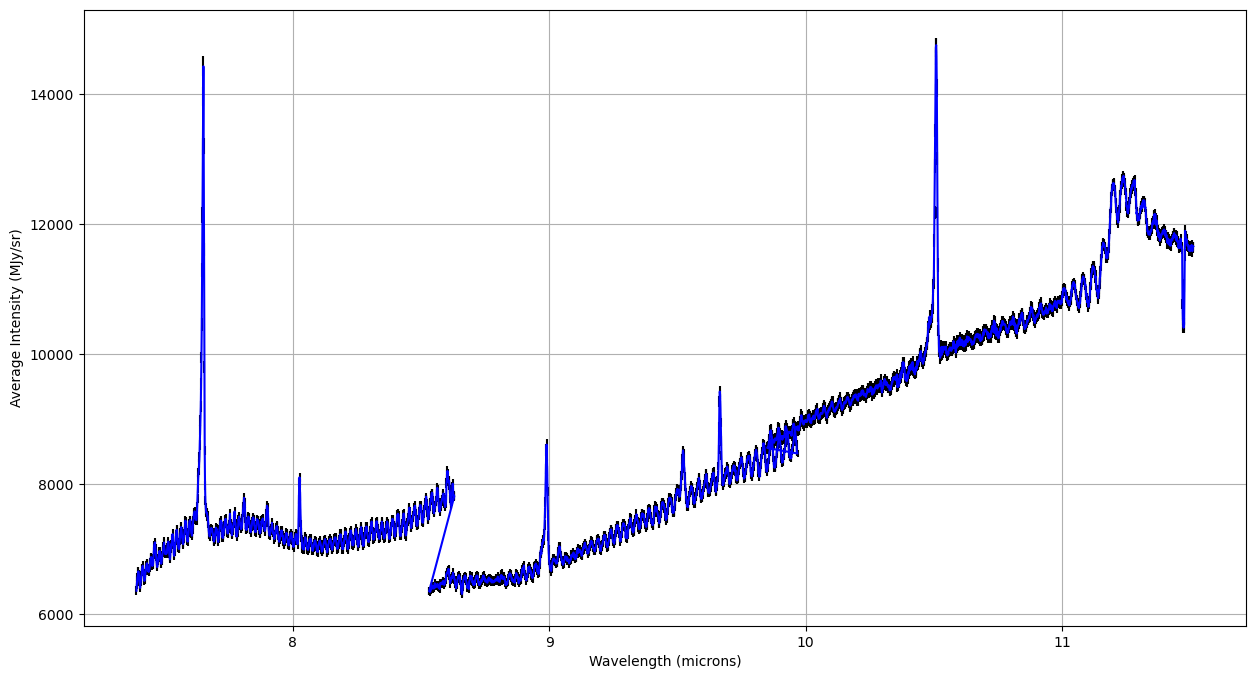

In [263]:
#Now same for all other channels
#For channel 2
z = 0.016268
reg_path = r"C:\Users\Dell\OneDrive\Desktop\JWST_FITS\d2.reg"
regs = Regions.read(reg_path, format='ds9')
f_paths = []
for part in ['short','medium','long']:
    f_paths.append(f'C:/Users/Dell/OneDrive/Desktop/JWST_FITS/ch2/jw01328-c1006_t014_miri_ch{2}-{part}_s3d.fits')
print(f_paths)
for region in regs: 
     spect_all = []
     spect_all_er = []
     wl_all = []
     for ch_index, f_path in enumerate(f_paths, start=1):
        spect = []
        spect_er = []
        with fits.open(f_path) as hdulist:
            d = hdulist[1].data
            d[d < 0] = np.nan  # Mask negative values
            d_err = hdulist[2].data
            h = hdulist[1].header
        wcs = WCS(h)
        mask = region.to_pixel(wcs.celestial).to_mask() 
        num_ch, ny, nx = d.shape
        n_wl = d.shape[0]
        crval3 = h['CRVAL3']   
        cdelt3 = h['CDELT3'] 
        crpix3 = h['CRPIX3']
        Wl = (np.arange(n_wl) - (crpix3 - 1)) * cdelt3 + crval3
        Wl = Wl / (1 + z)
        for i in range(num_ch):
            masked_d = np.array(mask.multiply(d[i, :, :]), dtype=float)
            masked_d_err = np.array(mask.multiply(d_err[i, :, :]), dtype=float)
            avg_intensity = np.nanmean(masked_d)
            avg_intensity_err = np.sqrt(np.nanmean(masked_d_err**2))
            if np.isnan(avg_intensity):
                avg_intensity = 0
            if np.isnan(avg_intensity_err):
                avg_intensity_err = 0
            spect.append(avg_intensity)
            spect_er.append(avg_intensity_err)
           
            wl_all.append(float(Wl[i]))
            spect_all.append(avg_intensity)
            spect_all_er.append(avg_intensity_err)

print(len(wl_all))
print(len(spect_all))
print(type(wl_all[0]))
print(type(spect_all[0]))
print(type(spect_all_er[0]))
plt.figure(figsize=(15, 8))
plt.errorbar(wl_all, spect_all, yerr=spect_all_er, color='blue', ecolor='black')
plt.xlabel('Wavelength (microns)')
plt.ylabel('Average Intensity (MJy/sr)')
plt.grid(True)


import plotly.graph_objects as go
import numpy as np

fig = go.Figure(layout=dict(
    width=800,  # Width in pixels
    height=500,  # Height in pixels
    template='plotly_white'
))
fig.add_trace(go.Scatter(
    x=wl_all,
    y=spect_all,
    mode='lines',
    line=dict(color='#1f77b4', width=1.5),
    name='Spectrum',
    hovertemplate='λ: %{x:.3f} μm<br>Intensity: %{y:.2f} MJy/sr<extra></extra>'
))
spect_all = np.array(spect_all)
spect_all_er = np.array(spect_all_er)
wl_all = np.array(wl_all)
fig.add_trace(go.Scatter(
    x=np.concatenate([wl_all, wl_all[::-1]]),
    y=np.concatenate([spect_all + spect_all_er, 
                     (spect_all - spect_all_er)[::-1]]),
    fill='toself',
    fillcolor='rgba(31, 119, 180, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo='skip',
    name='Uncertainty'
))

features = {
  'PAHs': {
         'PAH 7.7': 7.7, 'PAH 8.6': 8.6, 'PAH 11.3': 11.3,
    },
    'Iron': {
        
    },
    'Neon': {
         '[Ne VI]': 7.65,
    },
    'Other': {
         '[Ar III]': 8.991, 
        '[S IV]': 10.51
    },
    'H₂': {
         'S(3)': 9.66,
        'S(4)': 8.03
    }
}
colors = {
    'PAHs': '#FF7F0E',  # Orange
    'Iron': '#2CA02C',  # Green
    'Neon': '#9467BD',  # Purple
    'Other': '#D62728',  # Red
    'H₂': '#8C564B'     # Brown
}
for category, lines in features.items():
    for name, wl in lines.items():
        fig.add_vline(
            x=wl,
            line=dict(
                color=colors[category],
                width=1.5 if category == 'PAHs' else 1,
                dash='dot' if category != 'PAHs' else 'solid'
            ),
            annotation=dict(
                text=name,
                yanchor='bottom',
                font=dict(
                    size=10,
                    color=colors[category]
                ),
                yshift=10 if category == 'PAHs' else 0
            )
        )
for wl in [7.7,8.6,11.3]:  
    fig.add_vrect(
        x0=wl-0.15, x1=wl+0.15,
        fillcolor=colors['PAHs'],
        opacity=0.1,
        line_width=0
    )
fig.update_layout(
    title='<b>NGC 7469 JWST/MIRI IFU Spectrum with Molecular and Atomic Features</b>',
    xaxis_title='<b>Wavelength (μm)</b>',
    yaxis_title='<b>Intensity (MJy/sr)</b>',
    hovermode='x unified',                    
    legend=dict(                              
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    ),
    margin=dict(l=50, r=50, b=50, t=80),      
)
fig.show()

['C:/Users/Dell/OneDrive/Desktop/JWST_FITS/ch3/jw01328-c1006_t014_miri_ch3-short_s3d.fits', 'C:/Users/Dell/OneDrive/Desktop/JWST_FITS/ch3/jw01328-c1006_t014_miri_ch3-medium_s3d.fits', 'C:/Users/Dell/OneDrive/Desktop/JWST_FITS/ch3/jw01328-c1006_t014_miri_ch3-long_s3d.fits']


Set DATE-AVG to '2022-07-04T03:54:53.308' from MJD-AVG.
Set DATE-END to '2022-07-04T04:01:01.688' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -38.282938 from OBSGEO-[XYZ].
Set OBSGEO-H to 1737445726.821 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-07-04T04:11:30.971' from MJD-AVG.
Set DATE-END to '2022-07-04T04:17:32.407' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -38.283458 from OBSGEO-[XYZ].
Set OBSGEO-H to 1737461174.508 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-07-04T04:28:21.114' from MJD-AVG.
Set DATE-END to '2022-07-04T04:34:17.014' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -38.283980 from OBSGEO-[XYZ].
Set OBSGEO-H to 1737476710.042 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2689
2689
<class 'float'>
<class 'numpy.float64'>
<class 'numpy.float64'>


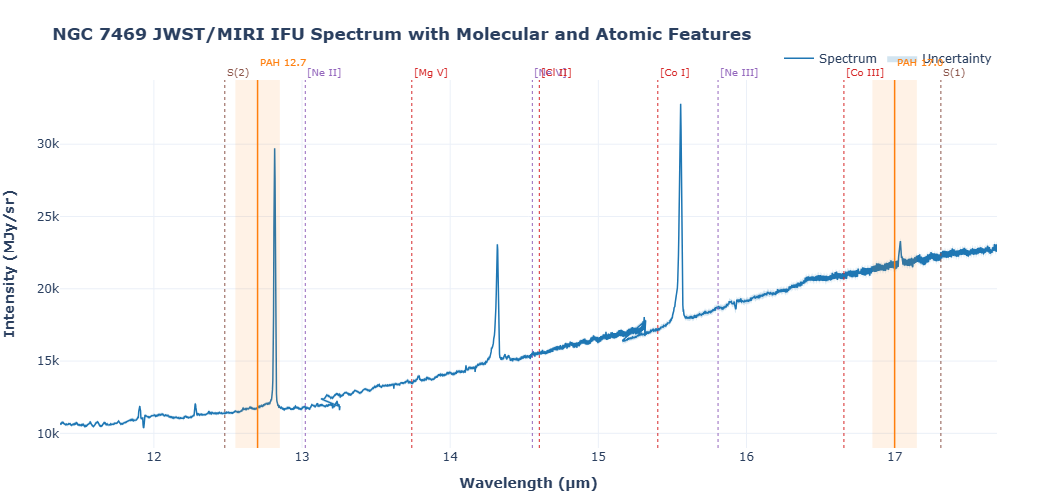

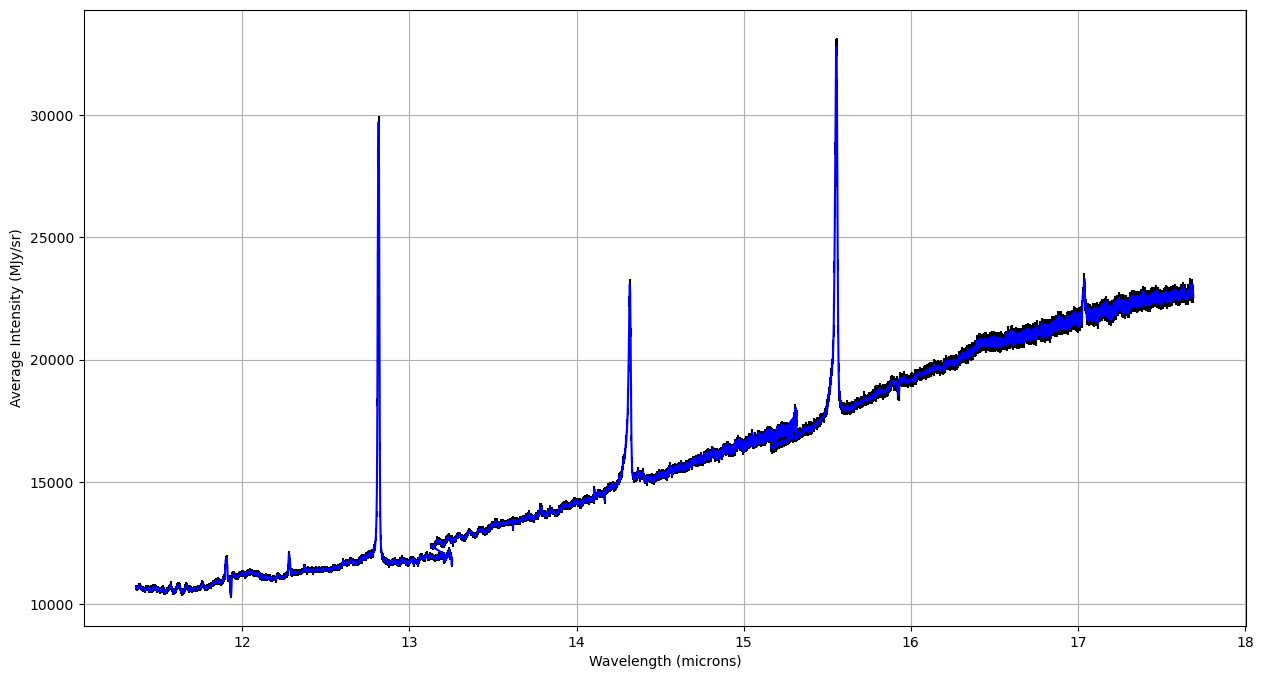

In [264]:
#For channel 3
z = 0.016268
reg_path = r"C:\Users\Dell\OneDrive\Desktop\JWST_FITS\d3.reg"
regs = Regions.read(reg_path, format='ds9')
f_paths = []
for part in ['short','medium','long']:
    f_paths.append(f'C:/Users/Dell/OneDrive/Desktop/JWST_FITS/ch3/jw01328-c1006_t014_miri_ch{3}-{part}_s3d.fits')
print(f_paths)
for region in regs: 
     spect_all = []
     spect_all_er = []
     wl_all = []
     for ch_index, f_path in enumerate(f_paths, start=1):
        spect = []
        spect_er = []
        with fits.open(f_path) as hdulist:
            d = hdulist[1].data
            d[d < 0] = np.nan  # Mask negative values
            d_err = hdulist[2].data
            h = hdulist[1].header
        wcs = WCS(h)
        mask = region.to_pixel(wcs.celestial).to_mask() 
        num_ch, ny, nx = d.shape
        n_wl = d.shape[0]
        crval3 = h['CRVAL3']   
        cdelt3 = h['CDELT3'] 
        crpix3 = h['CRPIX3']
        Wl = (np.arange(n_wl) - (crpix3 - 1)) * cdelt3 + crval3
        Wl = Wl / (1 + z)
        for i in range(num_ch):
            masked_d = np.array(mask.multiply(d[i, :, :]), dtype=float)
            masked_d_err = np.array(mask.multiply(d_err[i, :, :]), dtype=float)
            avg_intensity = np.nanmean(masked_d)
            avg_intensity_err = np.sqrt(np.nanmean(masked_d_err**2))
            if np.isnan(avg_intensity):
                avg_intensity = 0
            if np.isnan(avg_intensity_err):
                avg_intensity_err = 0
            spect.append(avg_intensity)
            spect_er.append(avg_intensity_err)
           
            wl_all.append(float(Wl[i]))
            spect_all.append(avg_intensity)
            spect_all_er.append(avg_intensity_err)

print(len(wl_all))
print(len(spect_all))
print(type(wl_all[0]))
print(type(spect_all[0]))
print(type(spect_all_er[0]))
plt.figure(figsize=(15, 8))
plt.errorbar(wl_all, spect_all, yerr=spect_all_er, color='blue', ecolor='black')
plt.xlabel('Wavelength (microns)')
plt.ylabel('Average Intensity (MJy/sr)')
plt.grid(True)


import plotly.graph_objects as go
import numpy as np

fig = go.Figure(layout=dict(
    width=800,  # Width in pixels
    height=500,  # Height in pixels
    template='plotly_white'
))
fig.add_trace(go.Scatter(
    x=wl_all,
    y=spect_all,
    mode='lines',
    line=dict(color='#1f77b4', width=1.5),
    name='Spectrum',
    hovertemplate='λ: %{x:.3f} μm<br>Intensity: %{y:.2f} MJy/sr<extra></extra>'
))
spect_all = np.array(spect_all)
spect_all_er = np.array(spect_all_er)
wl_all = np.array(wl_all)
fig.add_trace(go.Scatter(
    x=np.concatenate([wl_all, wl_all[::-1]]),
    y=np.concatenate([spect_all + spect_all_er, 
                     (spect_all - spect_all_er)[::-1]]),
    fill='toself',
    fillcolor='rgba(31, 119, 180, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo='skip',
    name='Uncertainty'
))

features = {
  'PAHs': {
         'PAH 12.7': 12.7, 'PAH 17.0': 17.0, 
    },
    'Neon': {
         '[Ne V]': 14.55466509024,
         '[Ne II]': 13.021990668719999,
         '[Ne III]': 15.808099553399998, 
    },
    'Other': {
        '[Mg V]': 13.740959628,
        #'[Ni I]': 15.055207568279998,
        '[Co I]': 15.40148056392,
        '[Cl II]': 14.6015353704,
        '[Co III]': 16.657648787999996
    },
    'H₂': {
         'S(1)': 17.312125379999998,
        'S(2)': 12.478754771999998
    }
}
colors = {
    'PAHs': '#FF7F0E',  # Orange
    'Iron': '#2CA02C',  # Green
    'Neon': '#9467BD',  # Purple
    'Other': '#D62728',  # Red
    'H₂': '#8C564B'     # Brown
}
for category, lines in features.items():
    for name, wl in lines.items():
        fig.add_vline(
            x=wl,
            line=dict(
                color=colors[category],
                width=1.5 if category == 'PAHs' else 1,
                dash='dot' if category != 'PAHs' else 'solid'
            ),
            annotation=dict(
                text=name,
                yanchor='bottom',
                font=dict(
                    size=10,
                    color=colors[category]
                ),
                yshift=10 if category == 'PAHs' else 0
            )
        )
for wl in [12.7,17.0]:  
    fig.add_vrect(
        x0=wl-0.15, x1=wl+0.15,
        fillcolor=colors['PAHs'],
        opacity=0.1,
        line_width=0
    )
fig.update_layout(
    title='<b>NGC 7469 JWST/MIRI IFU Spectrum with Molecular and Atomic Features</b>',
    xaxis_title='<b>Wavelength (μm)</b>',
    yaxis_title='<b>Intensity (MJy/sr)</b>',
    hovermode='x unified',                    
    legend=dict(                              
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    ),
    margin=dict(l=50, r=50, b=50, t=80),      
)
fig.show()

['C:/Users/Dell/OneDrive/Desktop/JWST_FITS/ch4/jw01328-c1006_t014_miri_ch4-short_s3d.fits', 'C:/Users/Dell/OneDrive/Desktop/JWST_FITS/ch4/jw01328-c1006_t014_miri_ch4-medium_s3d.fits', 'C:/Users/Dell/OneDrive/Desktop/JWST_FITS/ch4/jw01328-c1006_t014_miri_ch4-long_s3d.fits']


Set DATE-AVG to '2022-07-04T03:54:53.308' from MJD-AVG.
Set DATE-END to '2022-07-04T04:01:01.688' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -38.282938 from OBSGEO-[XYZ].
Set OBSGEO-H to 1737445726.821 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-07-04T04:11:30.971' from MJD-AVG.
Set DATE-END to '2022-07-04T04:17:32.407' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -38.283458 from OBSGEO-[XYZ].
Set OBSGEO-H to 1737461174.508 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1891
1891
<class 'float'>
<class 'numpy.float64'>
<class 'numpy.float64'>


Set DATE-AVG to '2022-07-04T04:28:21.114' from MJD-AVG.
Set DATE-END to '2022-07-04T04:34:17.014' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -38.283980 from OBSGEO-[XYZ].
Set OBSGEO-H to 1737476710.042 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


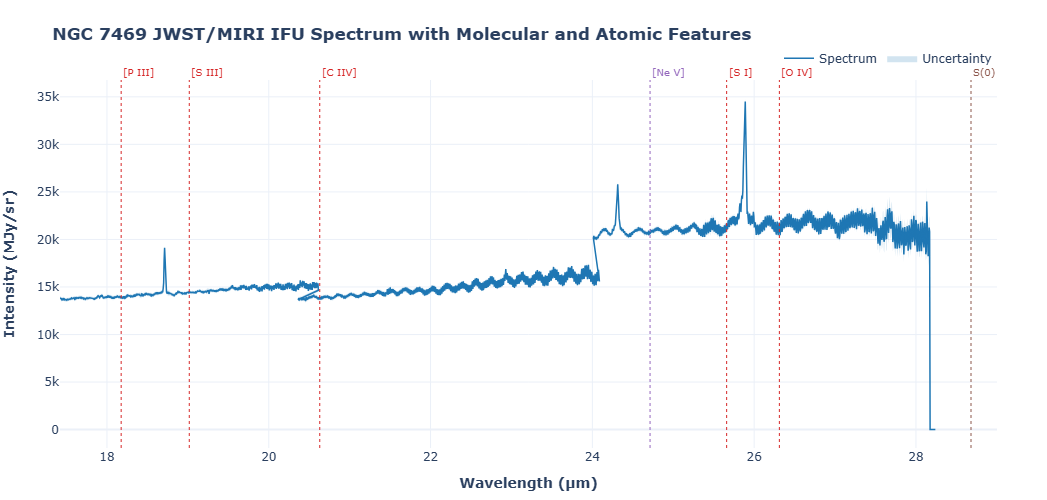

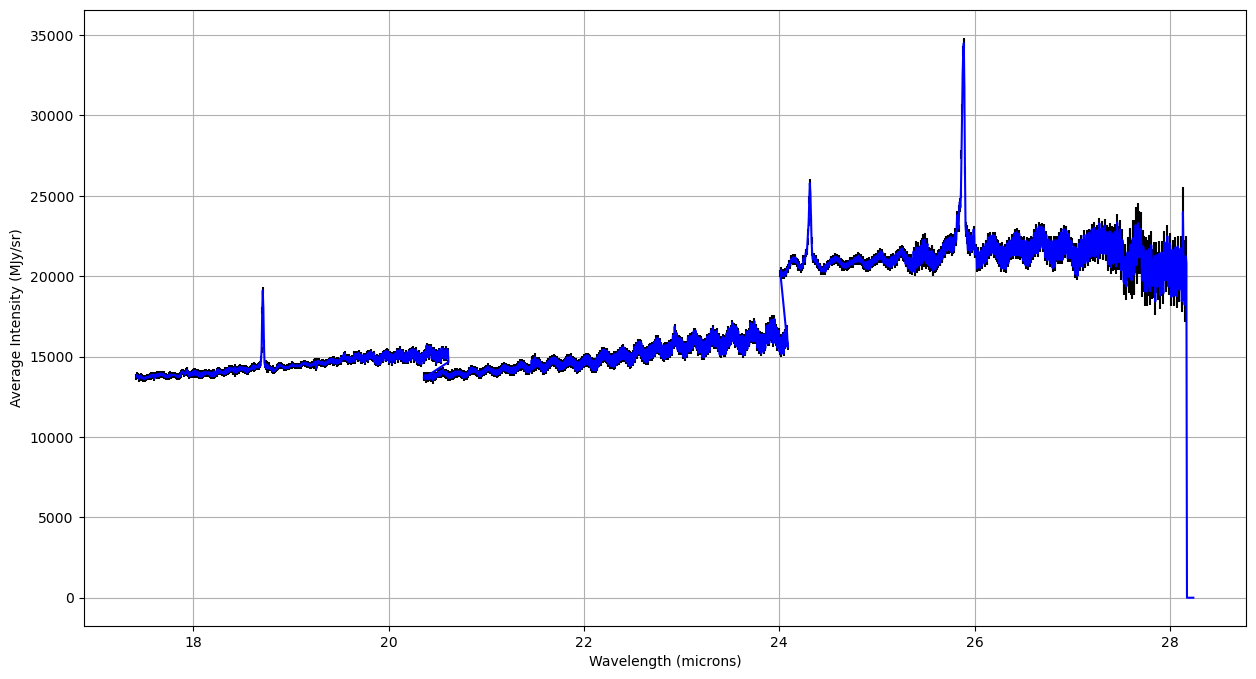

In [265]:
#For channel 4
z = 0.016268
reg_path = r"C:\Users\Dell\OneDrive\Desktop\JWST_FITS\d4.reg"
regs = Regions.read(reg_path, format='ds9')
f_paths = []
for part in ['short','medium','long']:
    f_paths.append(f'C:/Users/Dell/OneDrive/Desktop/JWST_FITS/ch4/jw01328-c1006_t014_miri_ch{4}-{part}_s3d.fits')
print(f_paths)
for region in regs: 
     spect_all = []
     spect_all_er = []
     wl_all = []
     for ch_index, f_path in enumerate(f_paths, start=1):
        spect = []
        spect_er = []
        with fits.open(f_path) as hdulist:
            d = hdulist[1].data
            d[d < 0] = np.nan  # Mask negative values
            d_err = hdulist[2].data
            h = hdulist[1].header
        wcs = WCS(h)
        mask = region.to_pixel(wcs.celestial).to_mask() 
        num_ch, ny, nx = d.shape
        n_wl = d.shape[0]
        crval3 = h['CRVAL3']   
        cdelt3 = h['CDELT3'] 
        crpix3 = h['CRPIX3']
        Wl = (np.arange(n_wl) - (crpix3 - 1)) * cdelt3 + crval3
        Wl = Wl / (1 + z)
        for i in range(num_ch):
            masked_d = np.array(mask.multiply(d[i, :, :]), dtype=float)
            masked_d_err = np.array(mask.multiply(d_err[i, :, :]), dtype=float)
            avg_intensity = np.nanmean(masked_d)
            avg_intensity_err = np.sqrt(np.nanmean(masked_d_err**2))
            if np.isnan(avg_intensity):
                avg_intensity = 0
            if np.isnan(avg_intensity_err):
                avg_intensity_err = 0
            spect.append(avg_intensity)
            spect_er.append(avg_intensity_err)
           
            wl_all.append(float(Wl[i]))
            spect_all.append(avg_intensity)
            spect_all_er.append(avg_intensity_err)

print(len(wl_all))
print(len(spect_all))
print(type(wl_all[0]))
print(type(spect_all[0]))
print(type(spect_all_er[0]))
plt.figure(figsize=(15, 8))
plt.errorbar(wl_all, spect_all, yerr=spect_all_er, color='blue', ecolor='black')
plt.xlabel('Wavelength (microns)')
plt.ylabel('Average Intensity (MJy/sr)')
plt.grid(True)


import plotly.graph_objects as go
import numpy as np

fig = go.Figure(layout=dict(
    width=800,  # Width in pixels
    height=500,  # Height in pixels
    template='plotly_white'
))
fig.add_trace(go.Scatter(
    x=wl_all,
    y=spect_all,
    mode='lines',
    line=dict(color='#1f77b4', width=1.5),
    name='Spectrum',
    hovertemplate='λ: %{x:.3f} μm<br>Intensity: %{y:.2f} MJy/sr<extra></extra>'
))
spect_all = np.array(spect_all)
spect_all_er = np.array(spect_all_er)
wl_all = np.array(wl_all)
fig.add_trace(go.Scatter(
    x=np.concatenate([wl_all, wl_all[::-1]]),
    y=np.concatenate([spect_all + spect_all_er, 
                     (spect_all - spect_all_er)[::-1]]),
    fill='toself',
    fillcolor='rgba(31, 119, 180, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo='skip',
    name='Uncertainty'
))

features = {
  'Iron': {
         #'[Fe II 7-9]':18.227803173359998,
         #'[Fe II]': 26.411169128519997, 
         #'[Fe III]': 23.2979439
    },
    'Neon': {
         '[Ne V]': 24.713097089999998,
    },
    'Other': {
        '[P III]': 18.1755466728,
        '[S I]': 25.659750732,
        '[C IIV]': 20.630240399999998,
        '[S III]': 19.017453572039997,
        #'[Ar III]': 22.1842157988,
        '[O IV]': 26.3114834004
    },
    'H₂': {
         'S(0)': 28.680099228,
    }
}
colors = {
    'Iron': '#2CA02C',  # Green
    'Neon': '#9467BD',  # Purple
    'Other': '#D62728',  # Red
    'H₂': '#8C564B'     # Brown
}
for category, lines in features.items():
    for name, wl in lines.items():
        fig.add_vline(
            x=wl,
            line=dict(
                color=colors[category],
                width=1.5 if category == 'PAHs' else 1,
                dash='dot' if category != 'PAHs' else 'solid'
            ),
            annotation=dict(
                text=name,
                yanchor='bottom',
                font=dict(
                    size=10,
                    color=colors[category]
                ),
                yshift=10 if category == 'PAHs' else 0
            )
        )
for wl in []:  
    fig.add_vrect(
        x0=wl-0.15, x1=wl+0.15,
        fillcolor=colors['PAHs'],
        opacity=0.1,
        line_width=0
    )
fig.update_layout(
    title='<b>NGC 7469 JWST/MIRI IFU Spectrum with Molecular and Atomic Features</b>',
    xaxis_title='<b>Wavelength (μm)</b>',
    yaxis_title='<b>Intensity (MJy/sr)</b>',
    hovermode='x unified',                    
    legend=dict(                              
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    ),
    margin=dict(l=50, r=50, b=50, t=80),      
)
fig.show()